# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [236]:
# import modules 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

In [253]:
# load data
data = pd.read_csv("../assets/admissions.csv")
data.shape

(400, 4)

In [254]:
data.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


## Part 1. Data Proprecessing

#### 1.1 Dealing with missing observations

In [255]:
# check missing values
data.dropna().count()

admit       397
gre         397
gpa         397
prestige    397
dtype: int64

In [256]:
# count missing values
data.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [257]:
data[data['gre'].isnull()]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0


In [258]:
data[data['gpa'].isnull()]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
236,1,660.0,NaN,NaN


In [259]:
data[data['prestige'].isnull()]


,admit,gre,gpa,prestige
236,1,660.0,NaN,NaN


In [8]:
#??? Question - how to show all rows with at least one missing value at one time?

In [260]:
# Method 1 - Create a dataset without missing values (only three missing values so I think it is ok to drop those.)
data_clean=data.dropna()
data_clean.shape

(397, 4)

In [261]:
# check average gre and gpa score level for each prestige
data.groupby('prestige')['gre','gpa'].mean()

,gre,gpa
prestige,,
1.0,611.803279,3.453115
2.0,596.621622,3.364027
3.0,574.876033,3.432893
4.0,570.149254,3.318358


In [262]:
# Method 2 - Create a dataset with filling missing values 
# filling prestige with mean
# filling gre and gpa with their column means by group of prestige colleges
# inspired by the article on how to deal with missing values shared by Nico
# https://chrisalbon.com/python/data_wrangling/pandas_missing_data/
data_fill = data.copy()
data_fill["prestige"].fillna(1.0, inplace=True)  #assigning prestige = 1 because gre=660
data_fill["gre"].fillna(data_fill.groupby('prestige')['gre'].transform('mean'), inplace=True)
data_fill["gpa"].fillna(data_fill.groupby('prestige')['gpa'].transform('mean'), inplace=True)
data_fill.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


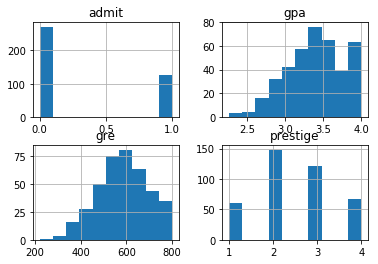

In [263]:
# Drop missing value table - frequency table for prestige and whether or not someone was admitted
prestige_freq = pd.crosstab(data_clean.admit, data_clean.prestige)
print(prestige_freq)
f=data_clean.hist()

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   97   93   55
1          34   53   28   12


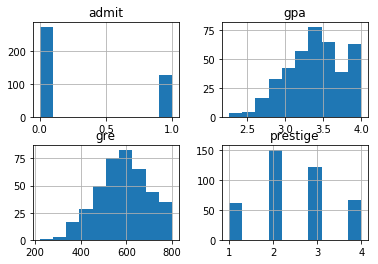

In [264]:
# Filling missing value table - frequency table for prestige and whether or not someone was admitted
prestige_freq = pd.crosstab(data_fill.admit, data_fill.prestige)
print(prestige_freq)
f=data_fill.hist()

##### No big difference is seen between dataset with dropping missing values and dataset with filling missing values. So I will use the dataset with filling missing values to run analysis. 

#### 1.2 Test for Colinearity

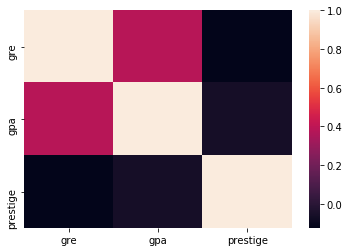

In [267]:
sns.heatmap(data[['gre','gpa','prestige']].corr())

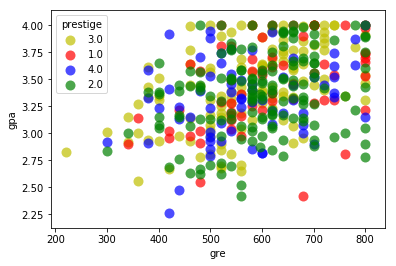

In [266]:
x_feature, y_feature = 'gre', 'gpa'
colors = pd.Series(['y', 'r', 'b', 'g'], index=data_fill.prestige.unique())
for pres in data_fill.prestige.unique():
    data_pres = data_fill[data_fill.prestige == pres]
    plt.scatter(data_pres[x_feature], data_pres[y_feature], c=colors[pres], label=pres,
                linewidths=0, s=100, alpha=0.7)
    plt.xlabel('gre'), plt.ylabel('gpa')
f = plt.legend(title='prestige')

From the plots above, we can see that correlation among predictors is low and no collinearity exists. 

(??? I'm not sure why the correlation heatmap shows low correlation among all predictors (all black colors) in the beginning but when I reran the code the heatmap shows gre and gpa correlate at some level (red color))

#### 1.3 Data Scaling

In [268]:
data[['gre','gpa']].std()

gre    115.628513
gpa      0.380630
dtype: float64

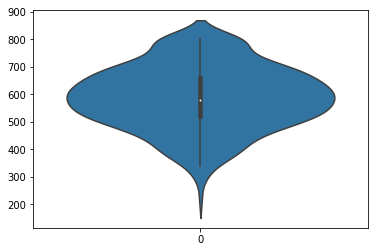

In [269]:
f=sns.violinplot(data=data_fill['gre'])

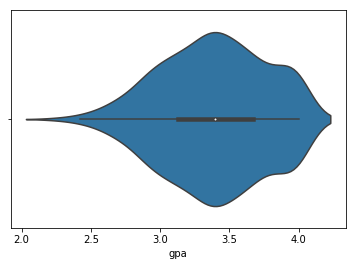

In [270]:
f=sns.violinplot(data_fill['gpa'])

From the above data description and violin plots, we can see both of GPA and GRE scores have marginal outliers. Also, GRE score has a much larger magnitude of scale than GPA score  and it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. To scaling the entire sample and shrinking the distance between outliers and inliers, I will use QuantileTransformer to scale the data. 

In [271]:
from sklearn.preprocessing import QuantileTransformer
X_scores = data_fill[['gre','gpa']]
X_scale =QuantileTransformer(output_distribution='normal').fit_transform(X_scores)
X_scale = pd.DataFrame(X_scale, columns=['gre','gpa'])
data_new=data_fill[['admit','prestige']].join(X_scale.loc[:,:])
data_new.head()

,admit,prestige,gre,gpa
0,0,3.0,-1.761948,0.523537
1,1,3.0,0.592444,0.684763
2,1,1.0,5.199338,5.199338
3,1,4.0,0.430727,-0.493553
4,0,4.0,-0.599937,-1.161976


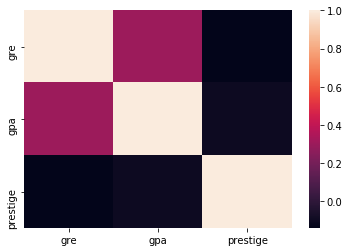

In [397]:
sns.heatmap(data_new[['gre','gpa','prestige']].corr())

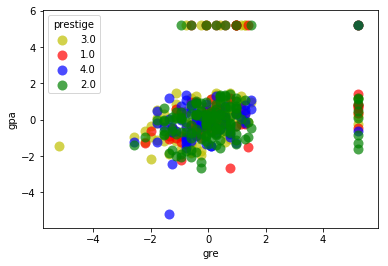

In [272]:
x_feature, y_feature = 'gre', 'gpa'
colors = pd.Series(['y', 'r', 'b', 'g'], index=data_new.prestige.unique())
for pres in data_new.prestige.unique():
    data_pres = data_new[data_new.prestige == pres]
    plt.scatter(data_pres[x_feature], data_pres[y_feature], c=colors[pres], label=pres,
                linewidths=0, s=100, alpha=0.7)
    plt.xlabel('gre'), plt.ylabel('gpa')
f = plt.legend(title='prestige')

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [273]:
dummies = pd.get_dummies(data_new.prestige,prefix='prestige')
df = pd.concat([data_new,dummies],axis =1)
df.head()

,admit,prestige,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,3.0,-1.761948,0.523537,0,0,1,0
1,1,3.0,0.592444,0.684763,0,0,1,0
2,1,1.0,5.199338,5.199338,1,0,0,0
3,1,4.0,0.430727,-0.493553,0,0,0,1
4,0,4.0,-0.599937,-1.161976,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We only need three class variables because the fourth one can be determined by another three. Removing one class variable among total four class variables can avoid multicollinearity. The removed variable can be the base category against which other categories can be compared

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [274]:
features = ['admit', 'gre', 'gpa']
handCalc = df[features].join(dummies.loc[:, 'prestige_1':])
handCalc.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,-1.761948,0.523537,0,0,1,0
1,1,0.592444,0.684763,0,0,1,0
2,1,5.199338,5.199338,1,0,0,0
3,1,0.430727,-0.493553,0,0,0,1
4,0,-0.599937,-1.161976,0,0,0,1


In [275]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
prestige1_freq = pd.crosstab(handCalc.admit, handCalc['prestige_1.0'])
prestige1_freq

prestige_1.0,0,1
admit,,
0,245,28
1,93,34


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [276]:
odds_attend = 34/28
print(odds_attend)

1.2142857142857142


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [277]:
odds_notattend = 93/245
print(odds_notattend)

0.3795918367346939


#### 3.3 Calculate the odds ratio

In [278]:
OR = odds_attend/odds_notattend
print(OR)

3.1989247311827955


#### 3.4 Write this finding in a sentenance: 

Answer: The odds of being admitted to the graduate school for students who attended top ranked colleges are three times the odds of being admitted to the graduate school for students who didn't. In other words, the odds of being admitted to graduate school are 2 times higher for students who attended a top ranked school compared to students who did not.

#### 3.5 Print the cross tab for prestige_4

In [279]:
prestige4_freq = pd.crosstab(handCalc.admit, handCalc['prestige_4.0'])
prestige4_freq

prestige_4.0,0,1
admit,,
0,218,55
1,115,12


#### 3.6 Calculate the OR 

In [280]:
OR = (12/55)/(115/218)
print(OR)

0.41359683794466406


#### 3.7 Write this finding in a sentence

Answer: The odds of being admitted to the graduate school for students who attended prestige 4 colleges were 60% lower than students who didn't attend

## Part 4. Analysis

In [282]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
datainput = df[cols_to_keep].join(dummies.loc[:, 'prestige_2':])
print (datainput.head())

   admit       gre       gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0 -1.761948  0.523537             0             1             0
1      1  0.592444  0.684763             0             1             0
2      1  5.199338  5.199338             0             0             0
3      1  0.430727 -0.493553             0             0             1
4      0 -0.599937 -1.161976             0             0             1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [283]:
# manually add the intercept
datainput['intercept'] = 1.0
datainput.head()

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,0,-1.761948,0.523537,0,1,0,1.0
1,1,0.592444,0.684763,0,1,0,1.0
2,1,5.199338,5.199338,0,0,0,1.0
3,1,0.430727,-0.493553,0,0,1,1.0
4,0,-0.599937,-1.161976,0,0,1,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [284]:
train_cols = datainput.columns[1:]
datainput[train_cols].head()

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,-1.761948,0.523537,0,1,0,1.0
1,0.592444,0.684763,0,1,0,1.0
2,5.199338,5.199338,0,0,0,1.0
3,0.430727,-0.493553,0,0,1,1.0
4,-0.599937,-1.161976,0,0,1,1.0


#### 4.2 Fit the model

In [285]:
model = sm.Logit(datainput.admit, datainput[train_cols])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.580491
         Iterations 5


#### 4.3 Print the summary results

In [286]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 21 Jan 2018   Pseudo R-squ.:                 0.07117
Time:                        09:50:26   Log-Likelihood:                -232.20
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 1.151e-06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gre              0.1180      0.073      1.615      0.106      -0.025       0.261
gpa              0.1484      0.071      2.099      0.036       0.010       0.287
prestige_2.0    -0.6949      0.314     -2.217      0.027      -1.309      -0.080
prestige_3.0    -1.3269      0.341     -3.892      0.000      -1.995      -0.659
prestige_4.0    -1.5445      0.416     -3.716      0.000      -2.359      -0.730
intercept        0.0337      0.265      0.127      0.899      -0.485       0.552
================================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [287]:
result.params

gre             0.117973
gpa             0.148427
prestige_2.0   -0.694948
prestige_3.0   -1.326885
prestige_4.0   -1.544452
intercept       0.033675
dtype: float64

In [288]:
np.exp(result.params)

gre             1.125213
gpa             1.160009
prestige_2.0    0.499100
prestige_3.0    0.265302
prestige_4.0    0.213429
intercept       1.034248
dtype: float64

In [289]:
confidence_interval = np.exp(result.conf_int())
confidence_interval.columns =['2.5%','97.5%']
confidence_interval['OR'] = np.exp(result.params)
confidence_interval

,2.5%,97.5%,OR
gre,0.975107,1.298426,1.125213
gpa,1.009891,1.332441,1.160009
prestige_2.0,0.269975,0.922682,0.499100
prestige_3.0,0.136008,0.517507,0.265302
prestige_4.0,0.094518,0.481939,0.213429
intercept,0.615828,1.736961,1.034248


#### 4.5 Interpret the OR of Prestige_2

Answer: The odds of being admitted to graduate school for students who attended prestige 2 colleges are 0.5 times the odds for students who attended top ranked colleges. In other words, the odds of being admitted for a student who attended prestige 2 colleges are 50% lower than students who attended top ranked colleges

#### 4.6 Interpret the OR of GPA

Answer: For one unit increase in gpa score, we expect to see about 16% increase in the odds of being admitted to the graduate school holding other variables constant.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [290]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    m = int(m)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [291]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data_new['gre'].min(), data_new['gre'].max(), 10)
print (gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data_new['gpa'].min(), data_new['gpa'].max(), 10)
print (gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.columns=['gre', 'gpa', 'prestige', 'intercept']
combos.head()

[-5.19933758 -4.04392923 -2.88852088 -1.73311253 -0.57770418  0.57770418
  1.73311253  2.88852088  4.04392923  5.19933758]
[-5.19933758 -4.04392923 -2.88852088 -1.73311253 -0.57770418  0.57770418
  1.73311253  2.88852088  4.04392923  5.19933758]


,gre,gpa,prestige,intercept
0,-5.199338,-5.199338,1.0,1.0
1,-5.199338,-5.199338,2.0,1.0
2,-5.199338,-5.199338,3.0,1.0
3,-5.199338,-5.199338,4.0,1.0
4,-5.199338,-4.043929,1.0,1.0


#### 5.1 Recreate the dummy variables

In [292]:
# recreate the dummy variables
dummies = pd.get_dummies(combos['prestige'],prefix ='prestige')

# keep only what we need for making predictions
data = combos[['gre','gpa','intercept','prestige']].join(dummies.loc[:,'prestige_2.0':])
data.head()

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,-5.199338,-5.199338,1.0,1.0,0,0,0
1,-5.199338,-5.199338,1.0,2.0,1,0,0
2,-5.199338,-5.199338,1.0,3.0,0,1,0
3,-5.199338,-5.199338,1.0,4.0,0,0,1
4,-5.199338,-4.043929,1.0,1.0,0,0,0


#### 5.2 Make predictions on the enumerated dataset

In [293]:
data['admit_pred'] = result.predict(data[train_cols])
data.tail(4)

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
396,5.199338,5.199338,1.0,1.0,0,0,0,0.805147
397,5.199338,5.199338,1.0,2.0,1,0,0,0.673450
398,5.199338,5.199338,1.0,3.0,0,1,0,0.522957
399,5.199338,5.199338,1.0,4.0,0,0,1,0.468623


#### 5.3 Interpret findings for the last 4 observations

Answer: Given the same gre and gpa score, the probability of being admitted to graduate school is positively correlated with prestige ranking - 80% probability of being admitted for studentis who attended prestige 1 college, 67% for prestige 2, 52% for prestige 3 and 47% for prestige 4. 

## Part.6 Plot the Probability

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

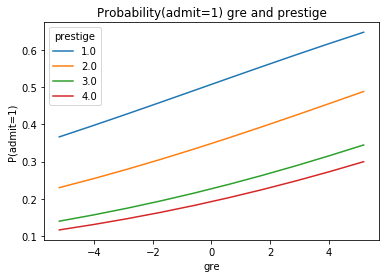

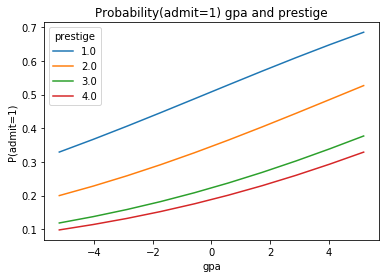

In [192]:
def prob_chart(variable):
    grouped = pd.pivot_table(data, index = [variable, 'prestige'], values =['admit_pred'], aggfunc = np.mean)
    for col in data.prestige.unique():
        plot_data = grouped[grouped.index.get_level_values(1)==col]
        plt.plot(plot_data.index.get_level_values(0), plot_data['admit_pred'])
    f=plt.legend(data.prestige.unique(), loc='upper left', title = 'prestige')
    f=plt.xlabel(variable)
    f=plt.ylabel('P(admit=1)')
    f=plt.title('Probability(admit=1) '+variable+" and prestige")
    plt.show()


prob_chart('gre')
prob_chart('gpa')

## Part .7 Use sklearn module to run Logistic Regression

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, KFold, train_test_split

In [399]:
df.head()

,admit,prestige,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,3.0,-1.761948,0.523537,0,0,1,0
1,1,3.0,0.592444,0.684763,0,0,1,0
2,1,1.0,5.199338,5.199338,1,0,0,0
3,1,4.0,0.430727,-0.493553,0,0,0,1
4,0,4.0,-0.599937,-1.161976,0,0,0,1


In [296]:
# train the model
#??? When using sklearn model, should I still need to create intercept? 
#.   I remember sklearn linear model can add intercept 
features = ['gre','gpa','prestige_2.0','prestige_3.0','prestige_4.0']
X,y = df[features], df.admit
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =.8, random_state=50)
model_logit = LogisticRegression()
model_logit.fit(X_train, y_train)
print(model_logit.score(X_train,y_train))
print(model_logit.score(X_test,y_test))

0.709375
0.6375


In [297]:
print(model_logit.predict(X)[:10])
print(model_logit.predict_proba(X)[:10])

[0 0 1 0 0 0 0 0 0 0]
[[ 0.80827631  0.19172369]
 [ 0.75929046  0.24070954]
 [ 0.25183777  0.74816223]
 [ 0.80863429  0.19136571]
 [ 0.83685681  0.16314319]
 [ 0.65276896  0.34723104]
 [ 0.55841397  0.44158603]
 [ 0.72080561  0.27919439]
 [ 0.79291652  0.20708348]
 [ 0.60804476  0.39195524]]


In [298]:
# check odds for training set
pd.DataFrame(np.exp(model_logit.coef_).T, index = features, columns =['odds'])

,odds
gre,1.122475
gpa,1.118383
prestige_2.0,0.552999
prestige_3.0,0.301116
prestige_4.0,0.261294


In [326]:
# check odds for the whole dataset 
model_logit.fit(X, y)
pd.DataFrame(np.exp(model_logit.coef_).T, index = features, columns =['odds'])

,odds
gre,1.129371
gpa,1.162222
prestige_2.0,0.608030
prestige_3.0,0.335164
prestige_4.0,0.290030


The odds results are alinged up with results generated from Statsmodel

??? how to use sklearn to calculate confidence interval?

In [301]:
# Evaluating model
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    print('%.10s is %.4f'% (metric,cross_val_score(model_logit, X,y, scoring=metric, cv=15).mean()))
print('baseline is ', 1-y.mean())

accuracy is 0.6898
precision is 0.4622
recall is 0.1463
f1 is 0.2157
roc_auc is 0.6558
baseline is  0.6825


/Users/celia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/celia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/celia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/celia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The cross-validation scores look low. The prediction accuracy rate is 68% and the precision rate is just 50% even lower than baseline score. 

#### Make predictions on the enumerated dataset

In [346]:
# From the above, the created and enumerated dataset is
data = combos[['gre','gpa','prestige']].join(dummies.loc[:,'prestige_2.0':])
data_sk = data.copy()
data_sk.head()

,gre,gpa,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,-5.199338,-5.199338,1.0,0,0,0
1,-5.199338,-5.199338,2.0,1,0,0
2,-5.199338,-5.199338,3.0,0,1,0
3,-5.199338,-5.199338,4.0,0,0,1
4,-5.199338,-4.043929,1.0,0,0,0


In [347]:
#model_logit.fit(X, y)
admit_pred = pd.Series(list(zip(*model_logit.predict_proba(data_sk[features])))[1])
data_sk['admit_pred']=admit_pred
#data['admit_pred'] = model_logit.predict_proba(data[features])
data_sk.tail(4)

,gre,gpa,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
396,5.199338,5.199338,1.0,0,0,0,0.779671
397,5.199338,5.199338,2.0,1,0,0,0.682703
398,5.199338,5.199338,3.0,0,1,0,0.542551
399,5.199338,5.199338,4.0,0,0,1,0.506494


Answer: The results of predicted admission probabilities are different from results predicted from Statsmodel. 

Statsmodel: prestige 1- 80%, prestige 2 - 67%, prestige 3 - 52%, prestige 4- 47%

## Part 8 Use K_nearest_neighbors estimator 

In [220]:
# to optimize K
from sklearn.neighbors import KNeighborsClassifier
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=.2)  # create training set, cv set, test set
scores = {}
for k in range(1, 50):
    scores[k] = []
    for i in range(20):
        X_train, X_cv, y_train, y_cv = train_test_split(X_train_cv, y_train_cv, train_size=.75)
        scores[k].append(KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).score(X_cv, y_cv))
sc = pd.DataFrame(scores)
sc.head()

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
0,0.6500,0.7500,0.6500,0.5875,0.6750,0.8125,0.6750,0.7500,0.7125,0.7125,...,0.8000,0.6750,0.7000,0.7000,0.750,0.6500,0.7000,0.6375,0.7000,0.6625
1,0.6250,0.6500,0.6250,0.6625,0.7125,0.6500,0.6875,0.6625,0.6625,0.7125,...,0.6250,0.7250,0.7375,0.7000,0.625,0.7000,0.6375,0.7750,0.6625,0.7625
2,0.6750,0.7125,0.6750,0.6375,0.6625,0.6625,0.7625,0.7375,0.6625,0.6375,...,0.6125,0.7375,0.7125,0.7000,0.725,0.5750,0.7500,0.6875,0.6375,0.7500
3,0.6750,0.7375,0.6250,0.7125,0.6875,0.7625,0.6375,0.7000,0.7125,0.6500,...,0.7125,0.6750,0.7125,0.7375,0.675,0.7000,0.7125,0.7500,0.7000,0.7125
4,0.6875,0.7250,0.5875,0.6500,0.7500,0.7000,0.6500,0.7375,0.7125,0.7500,...,0.6750,0.7250,0.7125,0.7250,0.675,0.7125,0.6875,0.7625,0.7000,0.7250


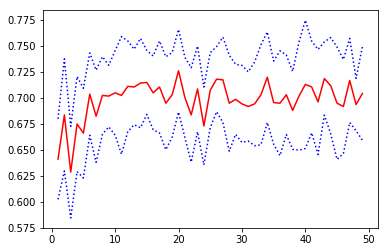

In [223]:
mu, std = sc.mean(), sc.std()
plt.plot(mu + std, ':b')
plt.plot(mu - std, ':b')
f = plt.plot(mu, 'r')

In [226]:
k = sc.mean().argmax()
print ("k =", k, "gives accuracy on optimization set of", sc.mean()[k])

k = 20 gives accuracy on optimization set of 0.72625


In [328]:
# Apply optimized k=20 to predict test set
model_k = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)
model_k.score(X_test, y_test)

0.65000000000000002

#### Make predictions on the test dataset

In [343]:
y_predict = pd.Series(model_k.predict(X_test),index=X_test.index, name='admit_pred')
data_predict = pd.concat([X_test,y_test,y_predict], axis=1)
data_predict.head(10)

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,admit,admit_pred
146,-0.947580,0.021329,1,0,0,0,0
332,-1.371657,-1.072973,0,0,0,0,0
67,0.260089,-0.299230,0,0,0,0,1
362,0.766391,-0.639462,1,0,0,0,0
102,-1.761948,-0.191865,0,0,1,0,0
305,-0.081638,0.174005,0,0,1,0,0
219,-0.247134,0.473810,1,0,0,1,0
97,-0.947580,0.408805,1,0,0,0,0
382,-0.417002,0.295296,1,0,0,0,0
248,0.766391,0.610484,0,1,0,0,0


The precision score is 65% and predicted results based on the test set have errors compared to actual admission results.

#### Make predictions on the enumerated dataset

In [349]:
# From the above, the created and enumerated dataset is
data = combos[['gre','gpa','prestige']].join(dummies.loc[:,'prestige_2.0':])
data_kneighbor=data.copy()
data_kneighbor.head()

,gre,gpa,prestige,prestige_2.0,prestige_3.0,prestige_4.0
0,-5.199338,-5.199338,1.0,0,0,0
1,-5.199338,-5.199338,2.0,1,0,0
2,-5.199338,-5.199338,3.0,0,1,0
3,-5.199338,-5.199338,4.0,0,0,1
4,-5.199338,-4.043929,1.0,0,0,0


In [353]:
data_kneighbor['admit_pred']= model_k.predict(data_kneighbor[features])
data_kneighbor.tail(4)

,gre,gpa,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
396,5.199338,5.199338,1.0,0,0,0,0
397,5.199338,5.199338,2.0,1,0,0,0
398,5.199338,5.199338,3.0,0,1,0,0
399,5.199338,5.199338,4.0,0,0,1,0


Different from Logistic Regression which predicts probabilities of the response variable - "being admitted", K-nearest neighbors estimator predicts categories (admit or not) directly. Those four records from the enumerated dataset show that all of them would not be admitted.  

## Part 9 Use Random Forests estimators

#### RandomForest Classifier

In [386]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import time
model_rf = RandomForestClassifier(n_estimators=10)
%time cross_val_score(model_rf, X, y).mean()

CPU times: user 44.1 ms, sys: 2.45 ms, total: 46.5 ms
Wall time: 44.5 ms


0.65495829125051441

In [387]:
# optimizing tree numbers
%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  
        accuracy = cross_val_score(model_rf, X, y).mean()  # out of sample accuracy
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores_rf = pd.DataFrame(scores)
scores_rf.head()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


,accuracy,criterion,duration,n_estimators
0,0.672502,gini,0.040967,1
1,0.657465,entropy,0.037504,1
2,0.662421,gini,0.037753,2
3,0.679909,entropy,0.038899,2
4,0.652433,gini,0.052060,3


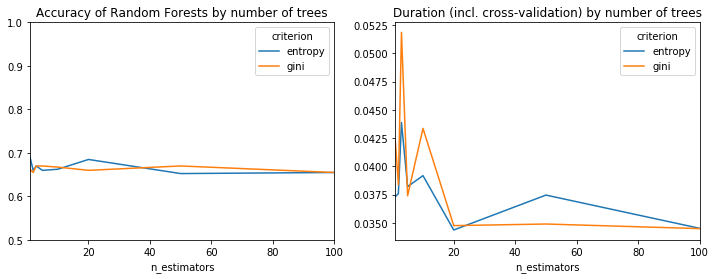

In [380]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = scores_rf.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees", ax=axes[0])
f = scores_rf.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    

In [381]:
scores_rf.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack()

criterion,entropy,gini
n_estimators,,
1,0.689915,0.662421
2,0.659990,0.654958
3,0.669977,0.669958
5,0.659952,0.669940
10,0.662440,0.667396
20,0.684959,0.659952
50,0.652508,0.670015
100,0.654977,0.654940


In [391]:
coef_rf = pd.Series(model_rf.feature_importances_, index=features).sort_values(inplace=False)
coef_rf

prestige_4.0    0.027204
prestige_2.0    0.037450
prestige_3.0    0.047270
gre             0.348774
gpa             0.539303
dtype: float64

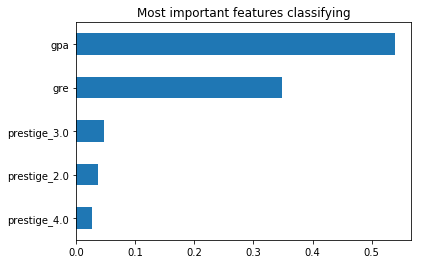

In [395]:
f = coef_rf[-15:].plot(kind='barh', title="Most important features classifying" )

#### AdaBoost Classifier

In [382]:
model_ada = AdaBoostClassifier(n_estimators=10)
%time cross_val_score(model_ada, X, y).mean()

CPU times: user 43.6 ms, sys: 2.07 ms, total: 45.7 ms
Wall time: 43.9 ms


0.6873901170837543

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 10 µs


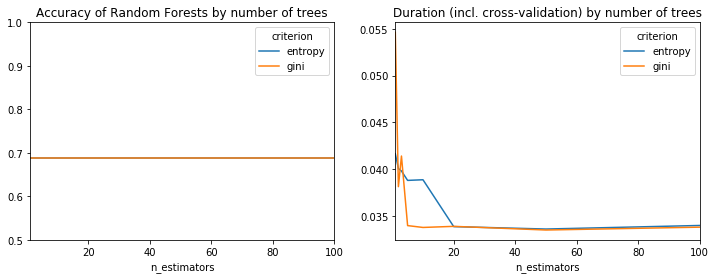

In [383]:
# optimizing tree numbers
%time
scores = []
for n in [1, 2, 3, 5, 10, 20, 50, 100]:
    for criterion in ['gini', 'entropy']:
        start_time = time.time()  
        accuracy = cross_val_score(model_ada, X, y).mean()  # out of sample accuracy
        duration = time.time() - start_time
        scores.append(dict(n_estimators=n, criterion=criterion, accuracy=accuracy, duration=duration))
scores_ada = pd.DataFrame(scores)
scores_ada.head()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = scores_ada.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack() \
    .plot(ylim=(.5,1), title="Accuracy of Random Forests by number of trees", ax=axes[0])
f = scores_ada.groupby(['n_estimators', 'criterion']).duration.mean().unstack() \
    .plot(title="Duration (incl. cross-validation) by number of trees", ax=axes[1])    

In [384]:
scores_ada.groupby(['n_estimators', 'criterion']).accuracy.mean().unstack()

criterion,entropy,gini
n_estimators,,
1,0.68739,0.68739
2,0.68739,0.68739
3,0.68739,0.68739
5,0.68739,0.68739
10,0.68739,0.68739
20,0.68739,0.68739
50,0.68739,0.68739
100,0.68739,0.68739
